# Apresentando os dados e descrição


## bibliotecas usadas

as bibliotecas usadas durante o projeto foram as recomendada e mais algumas para lidar com arquivos, visualização e etc

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import boxcox
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve, validation_curve)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

from zipfile import ZipFile
import urllib.request
import requests
import shutil
import os

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

### **Carregando e explorando a nossa base de dados**


A base de dados que utilizaremos é basicamente um arquivo de extensão .csv, e para realizarmos a manipulação e análise dos dados contidos nessa base de dados nós utilizaremos a biblioteca [`pandas`](https://pandas.pydata.org). 

tiamos disponiveis 4 banco de dados sobre caracterisiticas fisiologicas  de pessoas e diagnosticos de doenças cardiacas a qual escolhemos a base hungarian.csv por ser a mais consistente. Porem é necessario um forte tratamento desses dados o qual realizaremos a seguir.

In [32]:
# Antes de importar a base de dados para um DataFrame, vamos baixa-lá diretamente de um repositório do GitHub

url = 'https://codeload.github.com/gabriel-ferreira-da-silva/Naive-Bayes-On-Heart-Diseases-Data/zip/refs/heads/master'
r = requests.get(url, allow_redirects=True)

open('project.zip', 'wb').write(r.content)

if not os.path.isdir('project_data'):
    os.mkdir('project_data')
else:
    shutil.rmtree('project_data')
    os.mkdir('project_data')

urllib.request.urlretrieve(url)

with ZipFile('project.zip', 'r') as zipObj:
   zipObj.extractall('project_data')


df = pd.read_csv('/content/project_data/Naive-Bayes-On-Heart-Diseases-Data-master/dados/hungarian.csv')
features = df.columns[:-1].tolist()
allfeatures = df.columns.tolist()

print(df.shape)
print(features)
print(allfeatures)

(294, 15)
['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


Após importar a nossa base de dados para um `DataFrame`, nós podemos visualizar que a mesma consiste em 294 observações de pacientes e suas condições fisiologicas. 

A breve descrição presente no arquivo orginal da base de dados diz que existem 14 atributos importantes para um diagnostico de uma doença cardiaca. Dentre esses atributos esta o 'num'. O 'num' é um atributo de diagnostico de doença cardiaca o qual desejamos prever. 'num' varia entre 0 e 4, onde 0 significa um coração sauldavel e a partir de um significa um elevada dilatação nas arterias que indica uma doença cardiaca.


Abaixo podemos visualizar as últimas 15 desse total de 294 observações.

In [7]:
df.head(15)

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,1254,40,1,2,140,289,0,0,172,0,0.0,41,-9,-9,0
1,1255,49,0,3,160,180,0,0,156,0,1.0,-9,-9,-9,1
2,1256,37,1,2,130,283,0,1,98,0,0.0,2,-9,-9,0
3,1257,48,0,4,138,214,0,0,108,1,1.5,-9,-9,-9,3
4,1258,54,1,3,150,-9,0,0,122,0,0.0,2,-9,-9,0
5,1259,39,1,3,120,339,0,0,170,0,0.0,-9,-9,-9,0
6,1260,45,0,2,130,237,0,0,170,0,0.0,-9,-9,-9,0
7,1261,54,1,2,110,208,0,0,142,0,0.0,-9,-9,-9,0
8,1262,37,1,4,140,207,0,0,130,1,1.5,-9,-9,-9,1
9,1263,48,0,2,120,284,0,0,120,0,0.0,2,-9,-9,0


como podemos observar há uma série de dados poluidos e estranhos na nosso banco de dados. Primeiramente há uma série de numeros negativos, esta foi uma forma que os autores do BD acharam para representar dados nulos ou vazios.

outra é que algumas colunas foram repetidas e a coluna id serve apenas para identificar os pacientes. A forma como esses dados foi tratado será exposta nas proximas seções.

A seguir temos os tipos de dados disponiveis no BD.

In [9]:
df.dtypes

id            int64
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
num           int64
dtype: object

Por fim, podemos observar na saída da célula de código acima o tipo de cada campo da nossa base de dados.

## **2) Resumindo os dados**

### **Estatística descritiva**

Vamos primeiro resumir a distribuição das variáveis ​​numéricas.

In [10]:
df.describe()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.00000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,1195.853741,47.826531,0.724490,2.982993,132.102041,230.520408,-0.176871,0.187075,138.62585,0.272109,0.586054,-4.976190,-8.846939,-8.846939,0.792517
std,397.340367,7.811812,0.447533,0.965117,19.437564,95.414336,1.499491,0.707616,25.08408,0.711273,0.908648,5.869698,1.382623,1.382623,1.237006
min,1001.000000,28.000000,0.000000,1.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.00000,-9.000000,0.000000,-9.000000,-9.000000,-9.000000,0.000000
25%,1080.250000,42.000000,0.000000,2.000000,120.000000,198.000000,0.000000,0.000000,122.00000,0.000000,0.000000,-9.000000,-9.000000,-9.000000,0.000000
50%,1158.500000,49.000000,1.000000,3.000000,130.000000,237.000000,0.000000,0.000000,140.00000,0.000000,0.000000,-9.000000,-9.000000,-9.000000,0.000000
75%,1235.750000,54.000000,1.000000,4.000000,140.000000,277.000000,0.000000,0.000000,155.00000,1.000000,1.000000,2.000000,-9.000000,-9.000000,1.000000
max,5002.000000,66.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,190.00000,1.000000,5.000000,41.000000,9.000000,9.000000,4.000000


a metrica de nosso interesse é num que signica o tipo do diagnostico da doença cardiaca.

In [11]:
df['num'].value_counts()

0    188
1     37
3     28
2     26
4     15
Name: num, dtype: int64

vemos que maior parte dos nossos dados são de diagnosticos negativos,já que zero significa uma artéria normal.

### **Visualização de dados**

*   **Gráficos univariados**

Vamos dar uma olhada na distribuição dos diferentes recursos desse conjunto de dados.

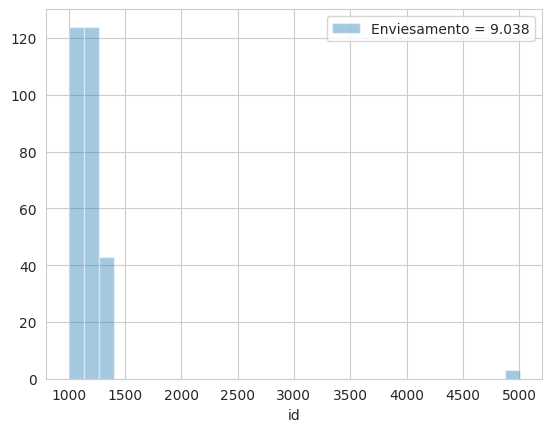

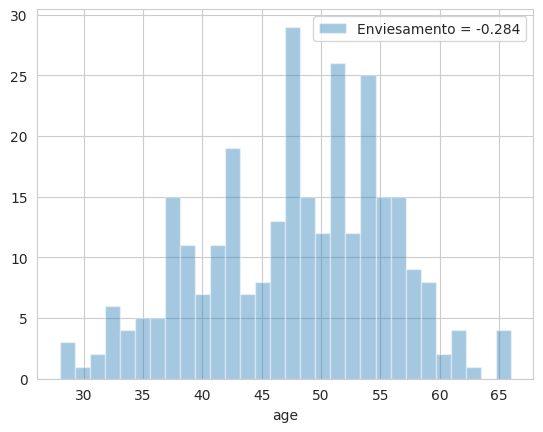

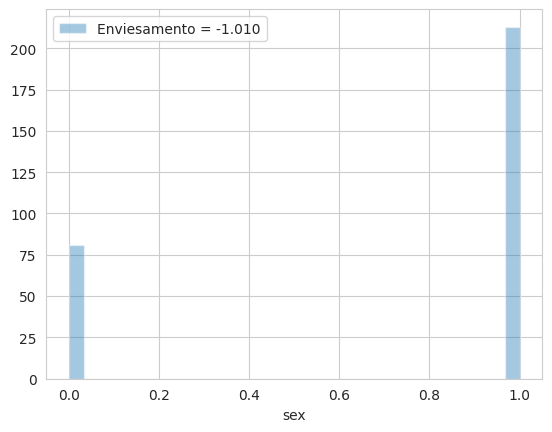

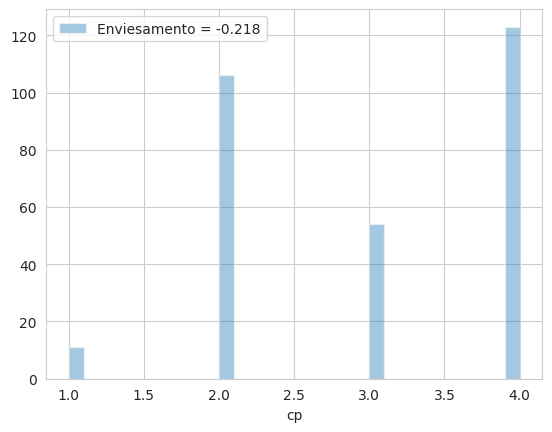

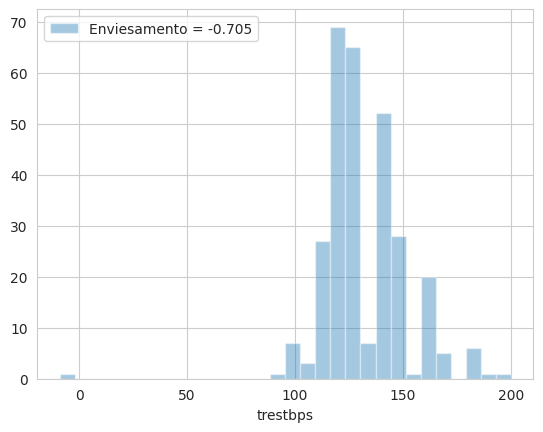

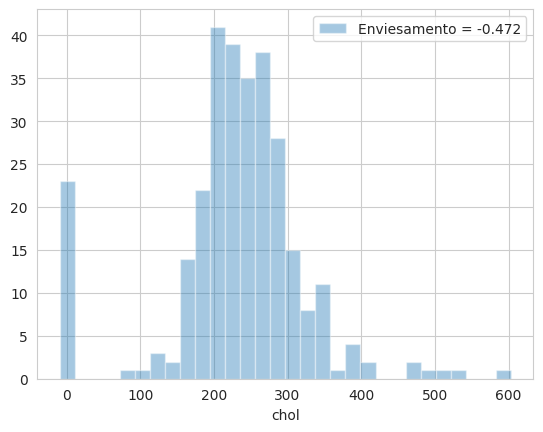

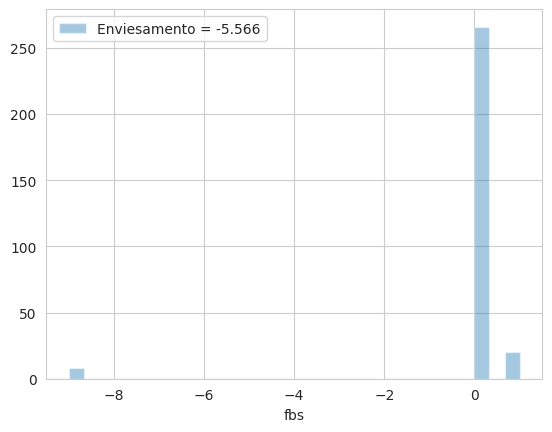

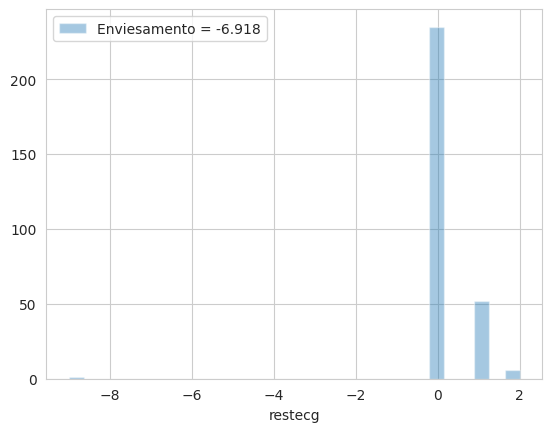

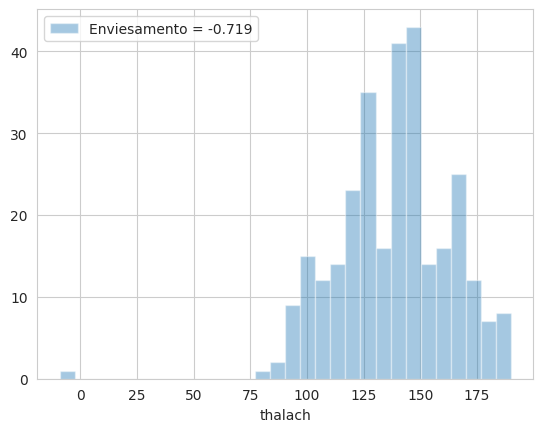

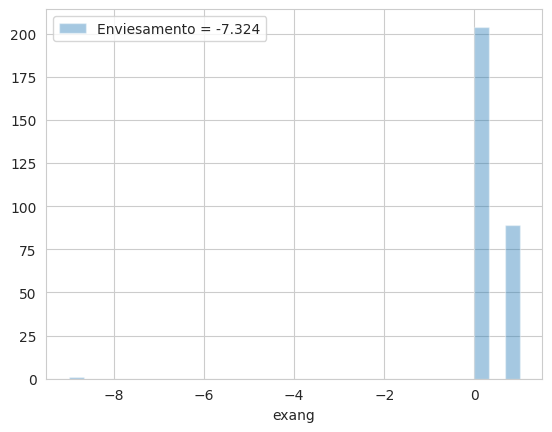

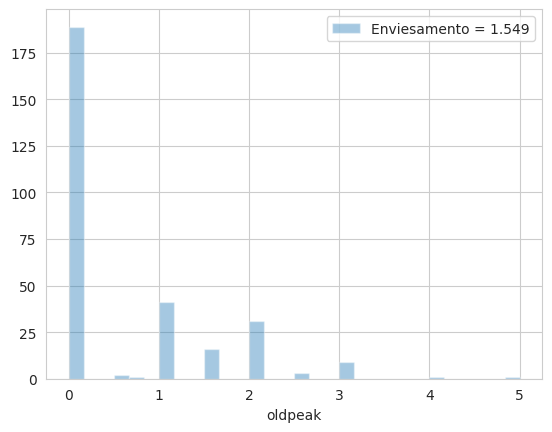

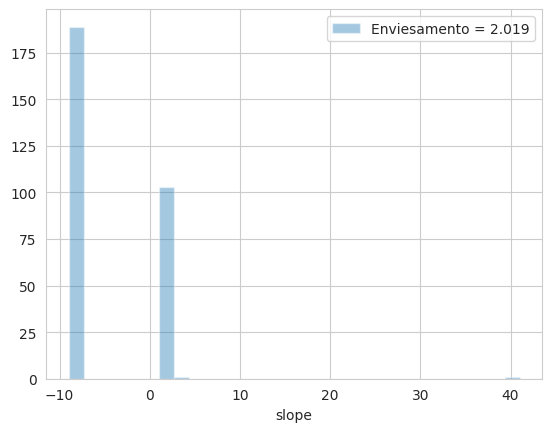

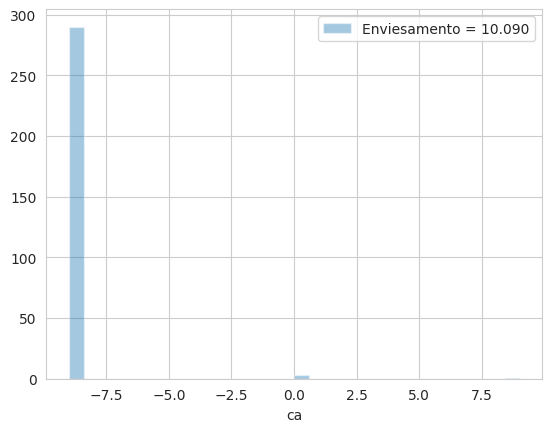

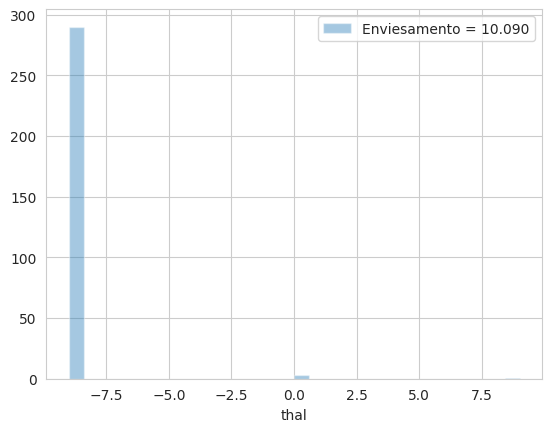

In [12]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Enviesamento = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

observamos uma serie de dados envisiados e presença de outliers em nossa base. Essas inconsistencias serão tratadas a seguir.

In [13]:
# Detecta observações com mais de um outlier

def outlier_hunt(df):
    outlier_indices = []
    
    # itera sobre as features (colunas)
    for col in df.columns.tolist():
        # primeiro quartil (25%)
        Q1 = np.percentile(df[col], 25)
        
        # terceiro quartil (75%)
        Q3 = np.percentile(df[col],75)
        
        # faixa interquartil
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR
        
        # Determina uma lista de índices de outliers para coluna de recurso
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # acrescenta os índices discrepantes encontrados para col à lista de índices discrepantes
        outlier_indices.extend(outlier_list_col)
        
    # selecionar observações contendo mais de 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('A base de dados contém %d observações com mais de 2 outliers' %(len(outlier_hunt(df[features]))))   

A base de dados contém 3 observações com mais de 2 outliers


Existem cerca de 3 observações com múltiplos outliers. Isso pode prejudicar a eficiência de nossos algoritmos de aprendizagem. Iremos nos livrar deles nas próximas seções.

Vamos examinar os boxplots para várias distribuições.

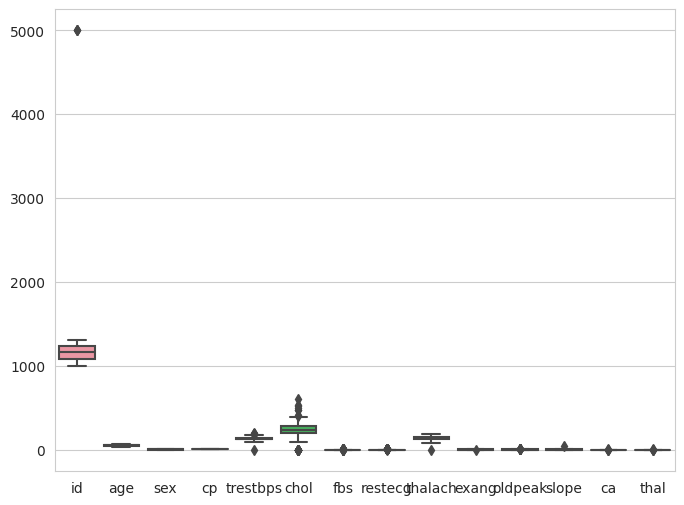

In [14]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[features])
plt.show()



*   **Gráficos Multivariados**


Vamos desenhar agora o pairplot para examinar visualmente a correlação entre as features.

<Figure size 800x800 with 0 Axes>

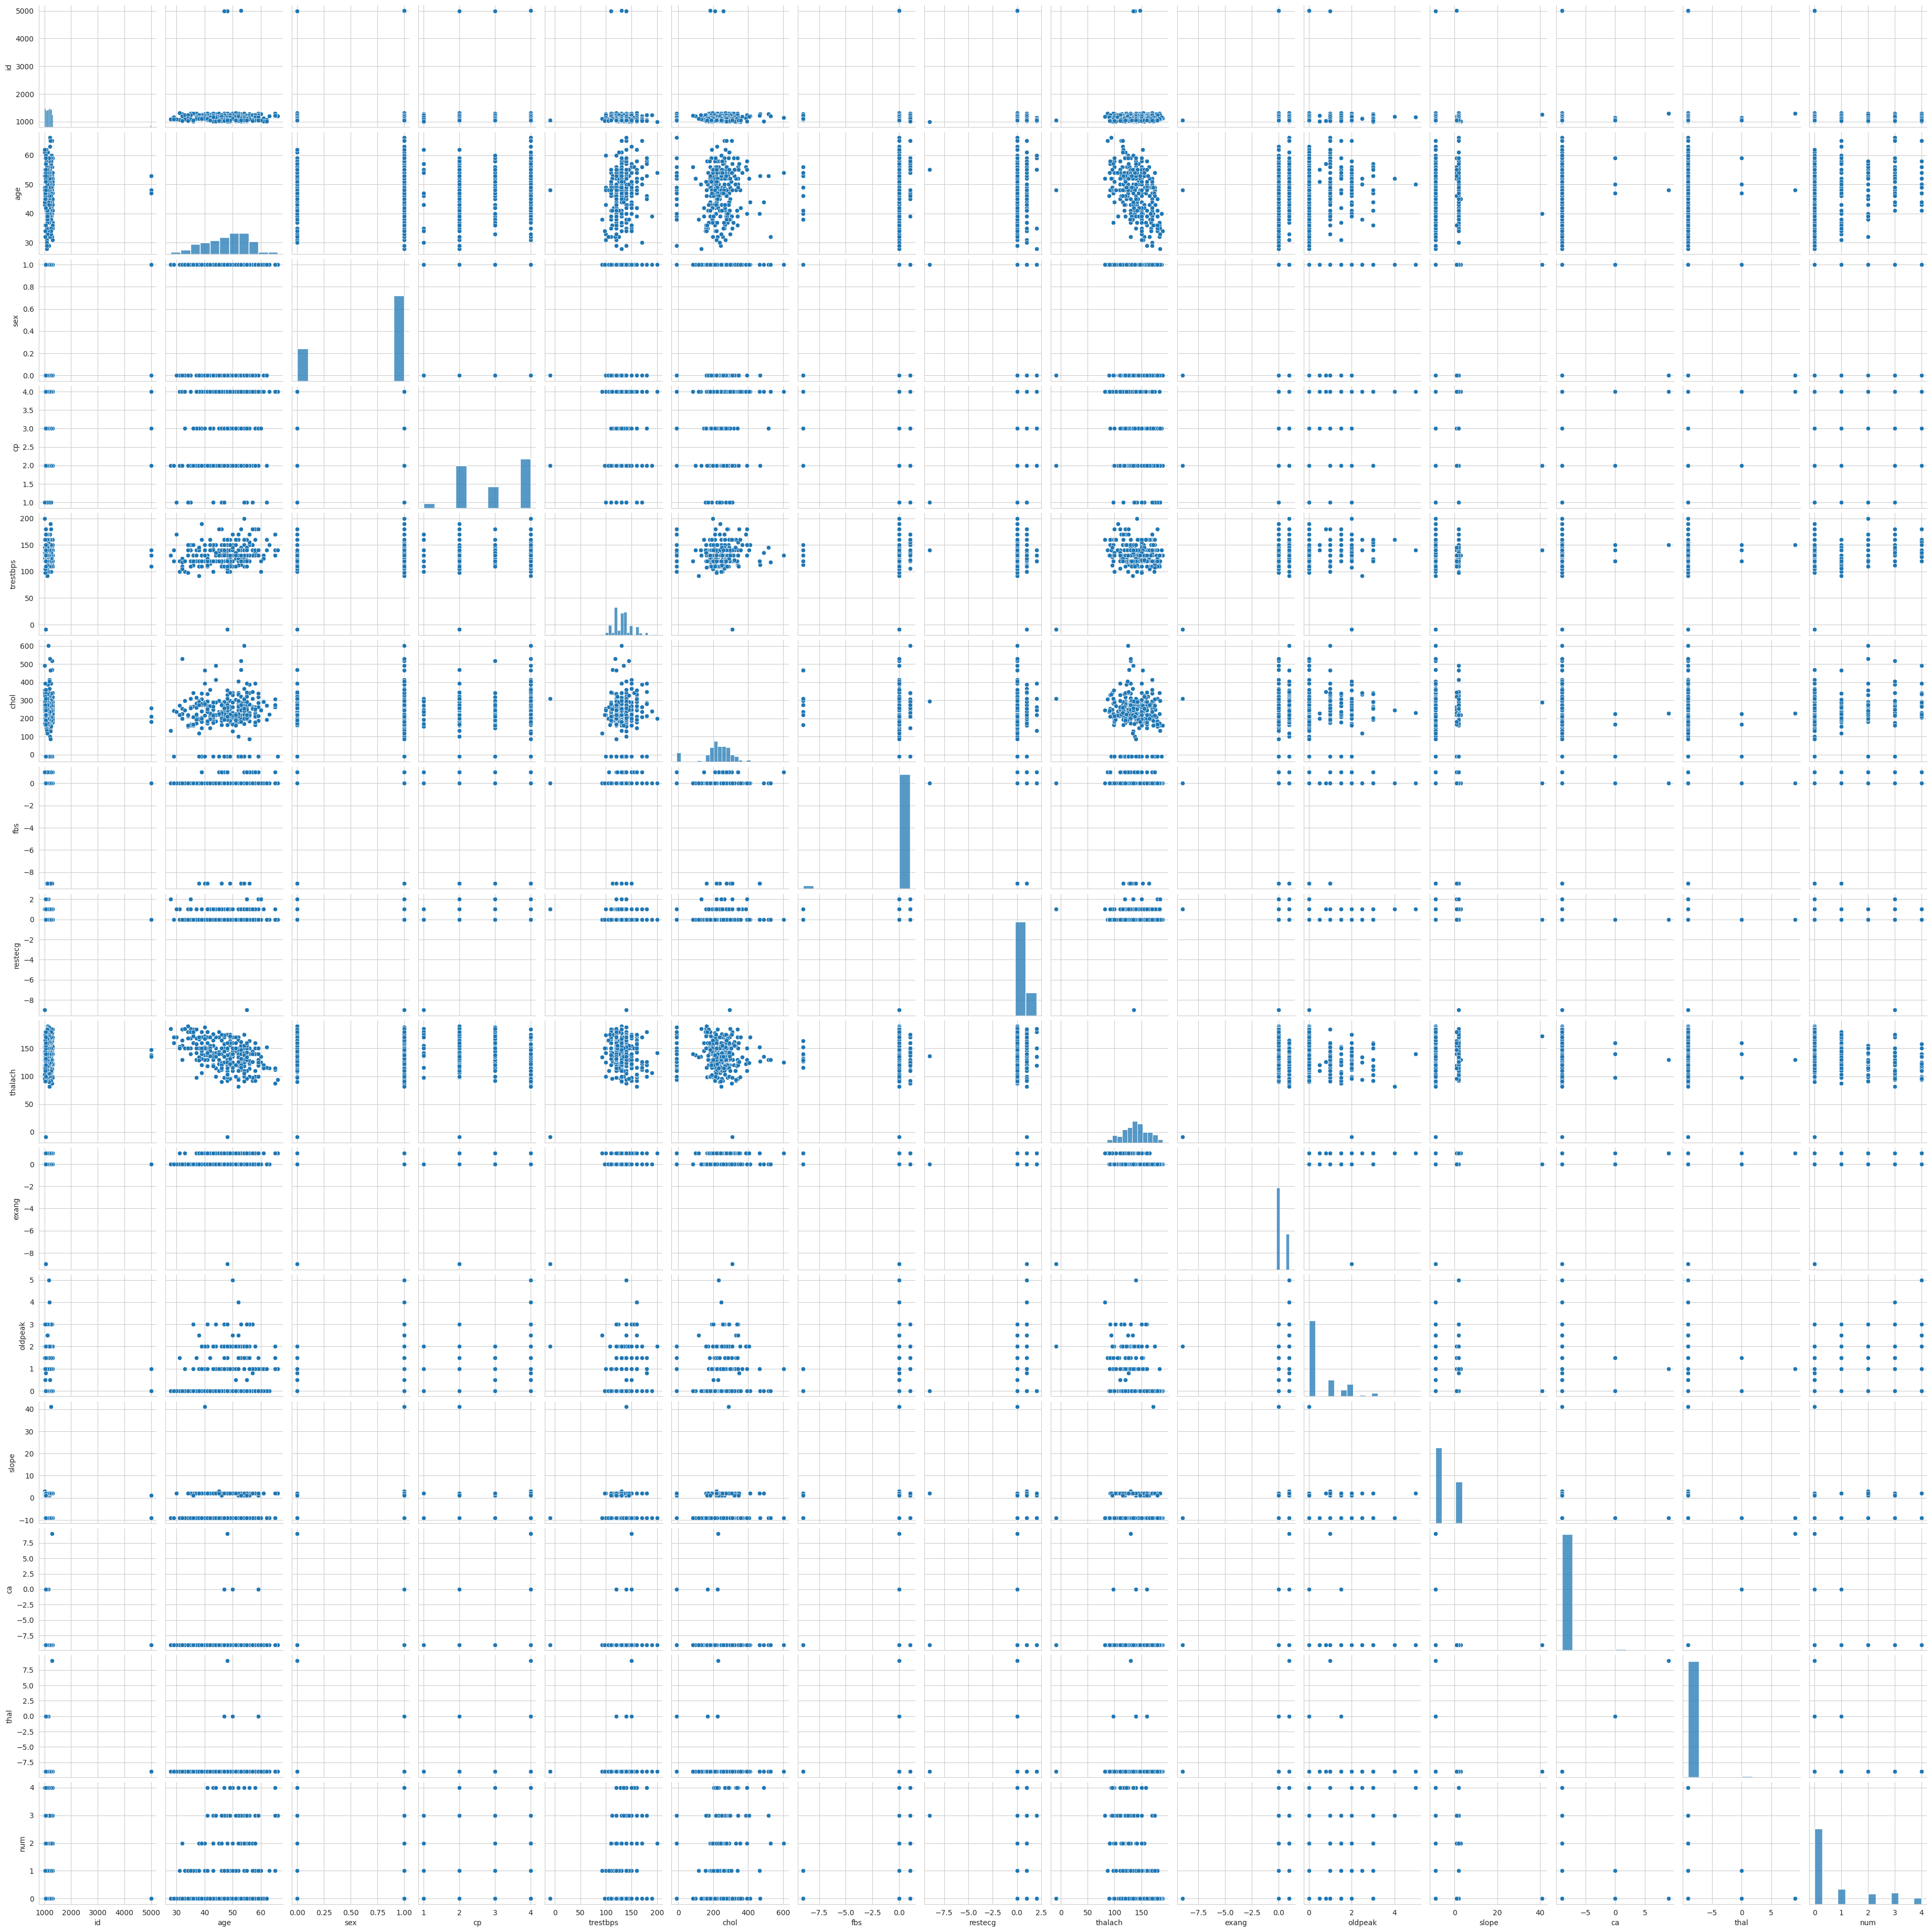

In [16]:
plt.figure(figsize=(8,8))
sns.pairplot(df[allfeatures],palette='coolwarm')
plt.show()

Agora iremos examinar o heatmap das correlações.

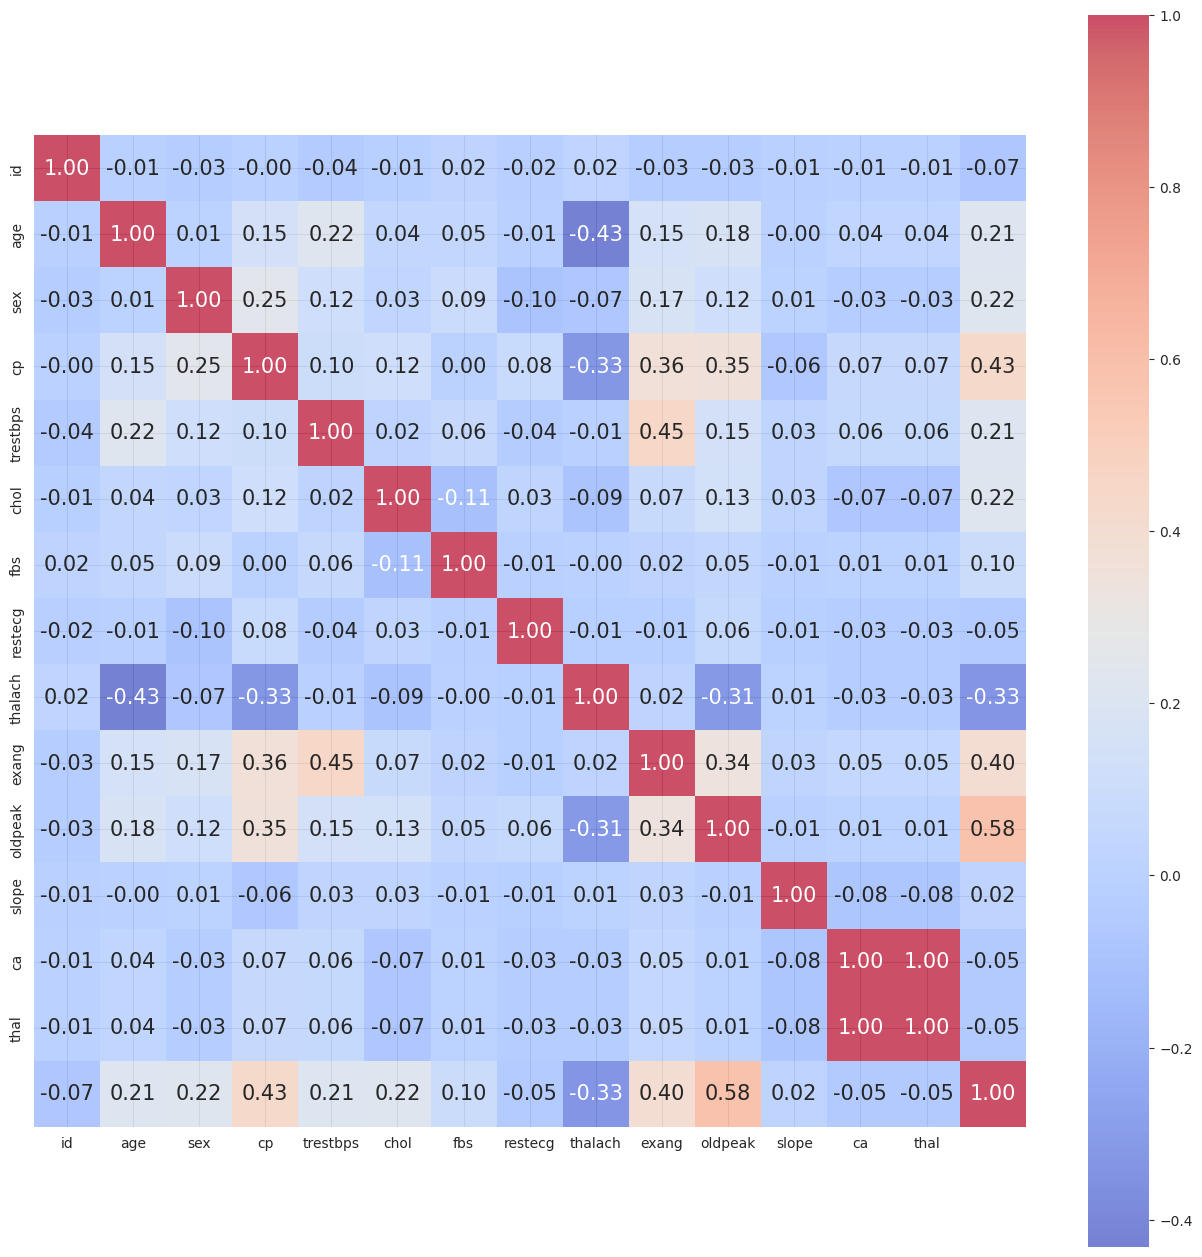

In [20]:
corr = df[allfeatures].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

aqui podemos tira algumas conclusões.  Primeiro os campos 'ca' e 'thal' da tabela são vazios por isso são muito correlacionados e devem ser excluidos.

## **3) Preparando os dados**

### **Tratamento de correlações entre as features**



Como o classificador ingênuo de Bayes considera que as features são independentes entre si, é necessário observar se essa condição é respeitada entre as features da base utilizada.

Para tratar os dados precisamos nos livrar das colunas que não tem dados ou cuja maioria dos dados sejam nulos e tambem nos livrar das linhas com dados nulos já que isso pode afetar resultados futuros.


In [33]:
print(features)
print(allfeatures)

df = df.drop(['thal'],axis=1)
features = df.columns[:-1].tolist()
allfeatures = df.columns[:-1].tolist()

print(features)
print(allfeatures)

df = df.drop(['ca'],axis=1)
features = df.columns[:-1].tolist()
allfeatures = df.columns[:-1].tolist()

allfeatures.append('num')

print(features)
print(allfeatures)


['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca']
['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca']
['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope']
['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'num']


In [34]:
df.head(15)

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
0,1254,40,1,2,140,289,0,0,172,0,0.0,41,0
1,1255,49,0,3,160,180,0,0,156,0,1.0,-9,1
2,1256,37,1,2,130,283,0,1,98,0,0.0,2,0
3,1257,48,0,4,138,214,0,0,108,1,1.5,-9,3
4,1258,54,1,3,150,-9,0,0,122,0,0.0,2,0
5,1259,39,1,3,120,339,0,0,170,0,0.0,-9,0
6,1260,45,0,2,130,237,0,0,170,0,0.0,-9,0
7,1261,54,1,2,110,208,0,0,142,0,0.0,-9,0
8,1262,37,1,4,140,207,0,0,130,1,1.5,-9,1
9,1263,48,0,2,120,284,0,0,120,0,0.0,2,0


Alem disso precisamos nos livrar das linhas com valores nulos

In [35]:
i=0
lines= []
for columm in df:
  for line in range(0, len(df[columm])):
    if df[columm][line] < 0:
      lines.append(line)
    
df = df.drop(lines, axis=0)



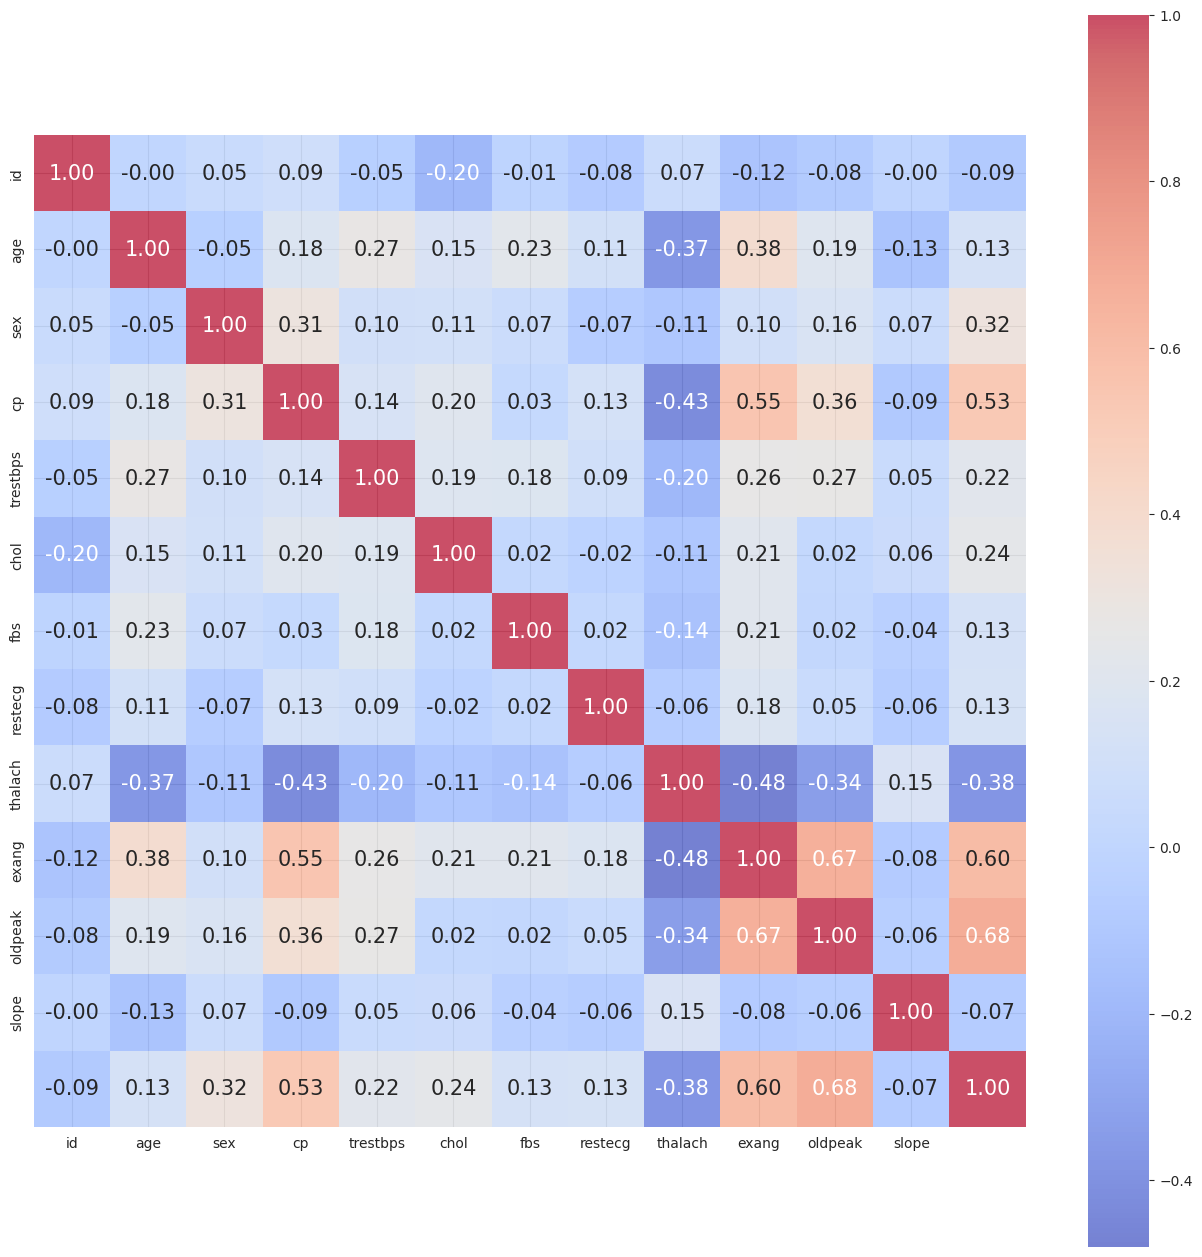

In [36]:
corr = df[allfeatures].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

Depois de eliminar alguns dados nulos vemos que as variveis tiveram seus valores de correlação alterado. vemos por exemplo que nossa variavel de interesse 'num' que representa o diagnostico de doença cardiaca, tem uma relação alta com:


*   cp : que representa tipo de dor no peito
*   exang :angina induzida por exercicio 
*   oldpeak : depressão induzida por exercicio relativa ao descanso

e tem uma anticorrelação com

*   thalach: maxima taxa cardiaca atingida




### **Limpeza de dados**

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 0 to 293
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        92 non-null     int64  
 1   age       92 non-null     int64  
 2   sex       92 non-null     int64  
 3   cp        92 non-null     int64  
 4   trestbps  92 non-null     int64  
 5   chol      92 non-null     int64  
 6   fbs       92 non-null     int64  
 7   restecg   92 non-null     int64  
 8   thalach   92 non-null     int64  
 9   exang     92 non-null     int64  
 10  oldpeak   92 non-null     float64
 11  slope     92 non-null     int64  
 12  num       92 non-null     int64  
dtypes: float64(1), int64(12)
memory usage: 10.1 KB



Como podemos notar, esta base de dados está limpa, não faltam valores nela.

### **Localizando e removendo os outliers**


Agora, nós iremos remover as observações que contêm múltiplos outliers com a função que criamos na seção anterior.

In [38]:
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(92, 13)


a remoção de outliers e dados nulos reduziu consideravelmente a nossa base de dados. De 294 observações sobraram apenas 92.

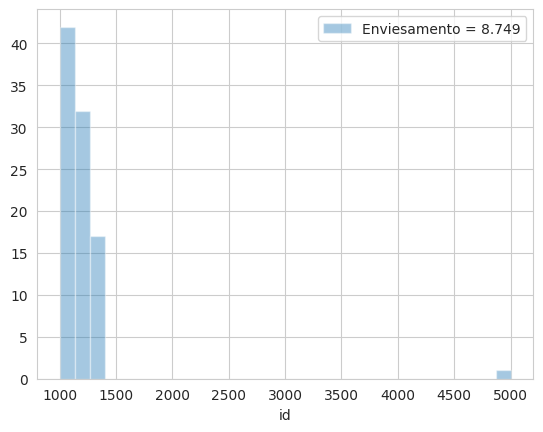

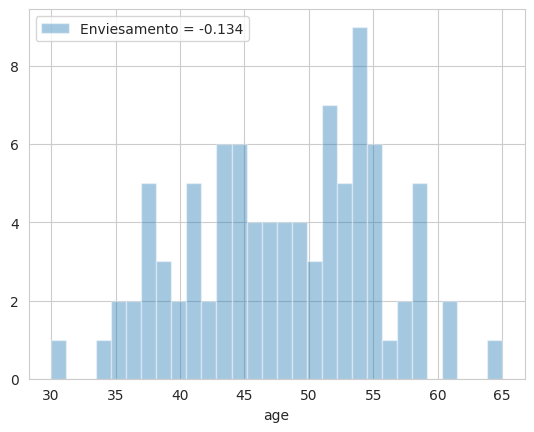

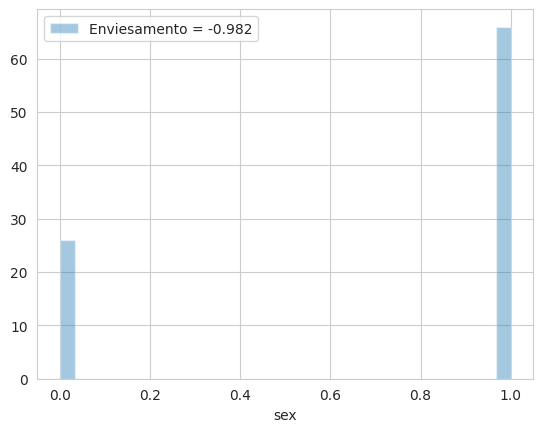

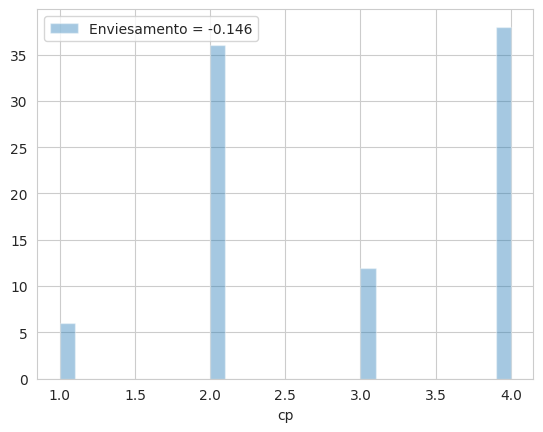

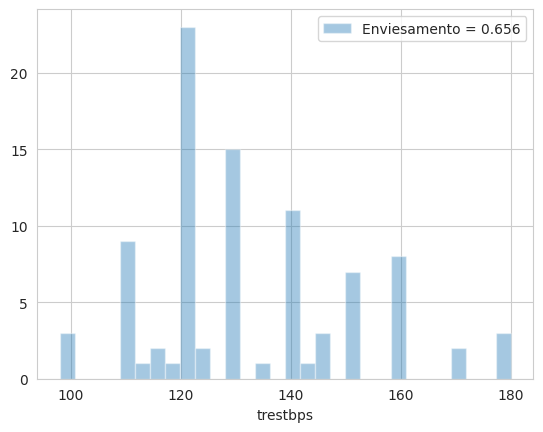

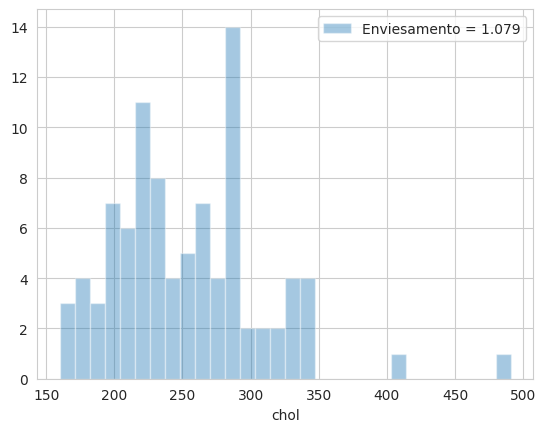

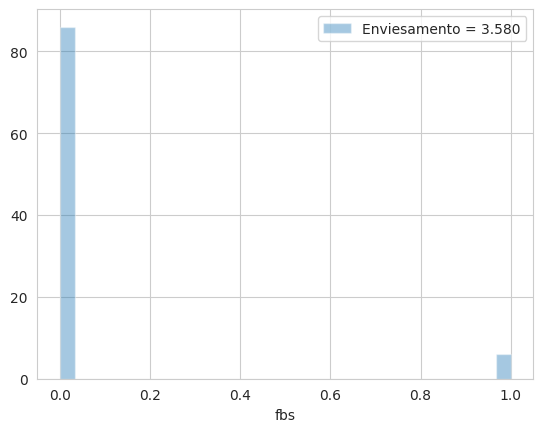

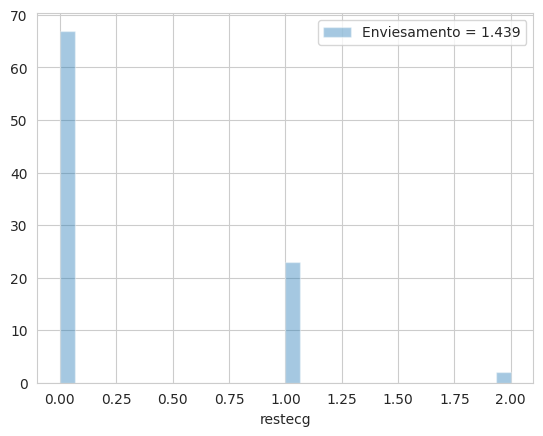

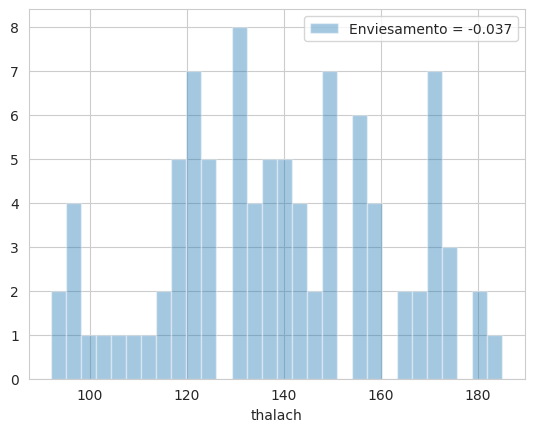

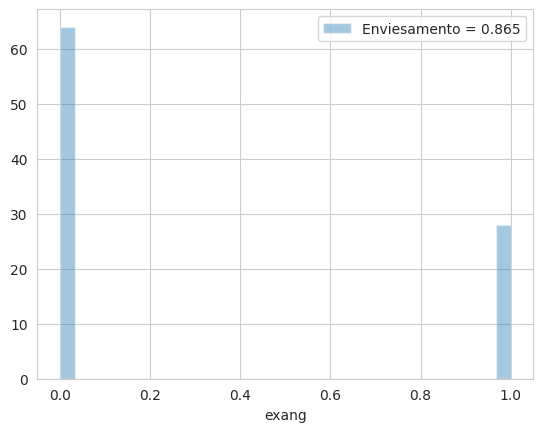

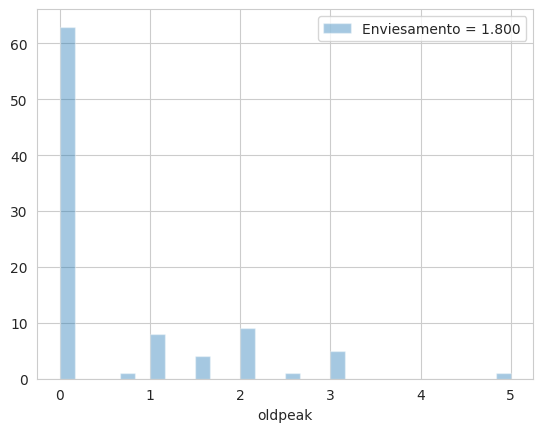

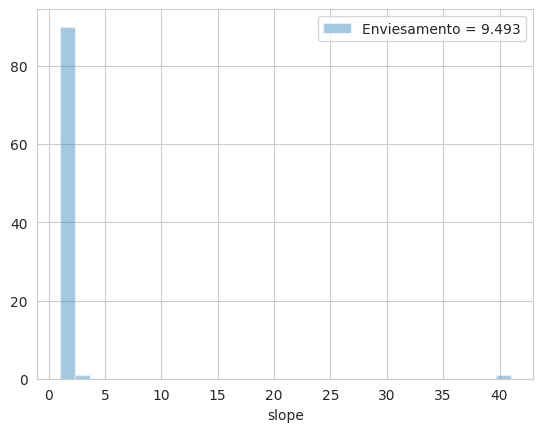

In [39]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde=False, label='Enviesamento = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [ ]:
df['num'].value_counts()

0    62
3    10
1     7
4     7
2     6
Name: num, dtype: int64

### **Separando o cojunto de dados de validação**



In [40]:
# Define X como as features e y como as labels
X = df[features] 
y = df['num'] 

seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

### **Transformação de dados**



Vamos examinar se uma transformação Box-Cox pode contribuir para a normalização de alguns recursos. Deve-se enfatizar que todas as transformações devem ser feitas apenas no conjunto de treinamento para evitar espionagem de dados. Caso contrário, a estimativa do erro de teste será tendenciosa.

In [41]:
features_boxcox = []

for feature in features:
    bc_transformed, _ = boxcox(df[feature]+1)
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
df_bc = pd.DataFrame(data=features_boxcox, columns=features)
df_bc['num'] = df['num']

In [42]:
df_bc.describe()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
count,9.200000e+01,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,3.172914e-01,114.688072,3.096595,2.951904,0.937717,1.951365,0.002948,0.059903,132.462280,0.075098,0.118936,0.601081,0.836957
std,2.178506e-11,22.022099,1.954215,1.064621,0.000762,0.015075,0.011223,0.098613,21.631840,0.114160,0.176973,0.051063,1.360972
min,3.172914e-01,63.280134,0.000000,1.009166,0.935872,1.916723,0.000000,0.000000,88.290633,0.000000,0.000000,0.472196,0.000000
25%,3.172914e-01,98.928099,0.000000,2.030859,0.937256,1.941531,0.000000,0.000000,114.826078,0.000000,0.000000,0.613335,0.000000
50%,3.172914e-01,114.546172,4.316465,3.060773,0.937727,1.952104,0.000000,0.000000,131.846001,0.000000,0.000000,0.613335,0.000000
75%,3.172914e-01,132.987735,4.316465,4.096843,0.938230,1.962477,0.000000,0.219681,147.896990,0.246751,0.341418,0.613335,1.250000
max,3.172914e-01,168.277866,4.316465,4.096843,0.939284,1.994274,0.045205,0.229221,176.174374,0.246751,0.417986,0.831349,4.000000


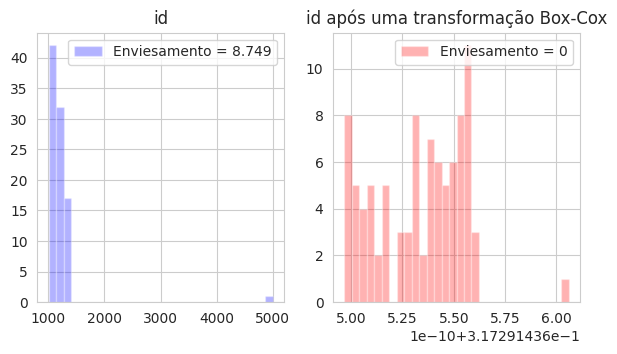

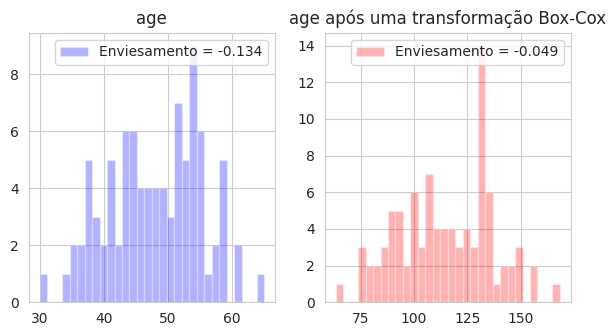

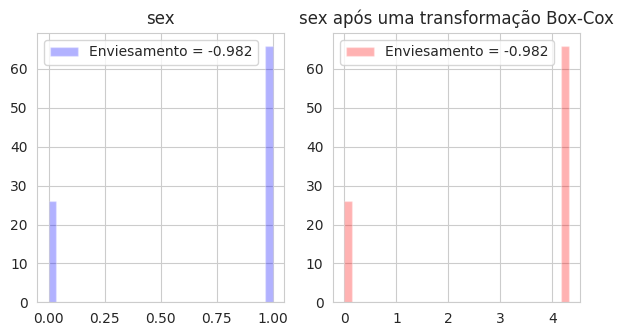

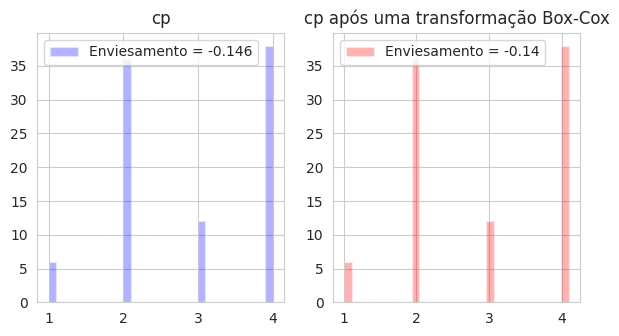

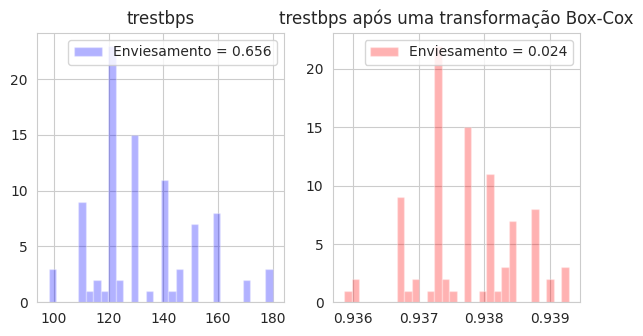

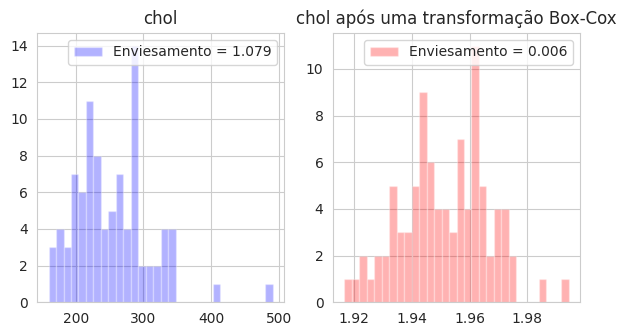

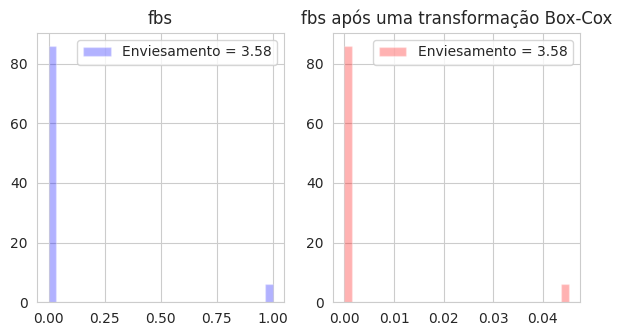

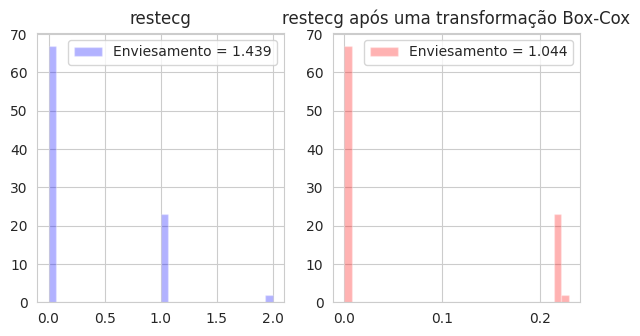

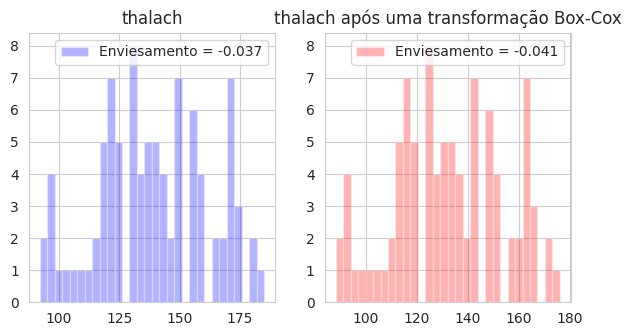

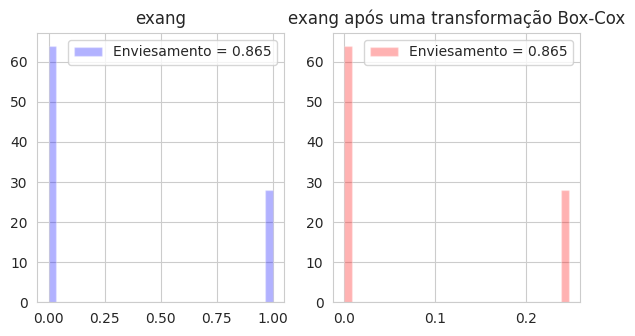

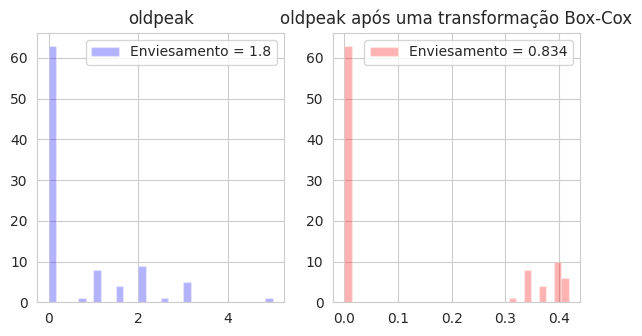

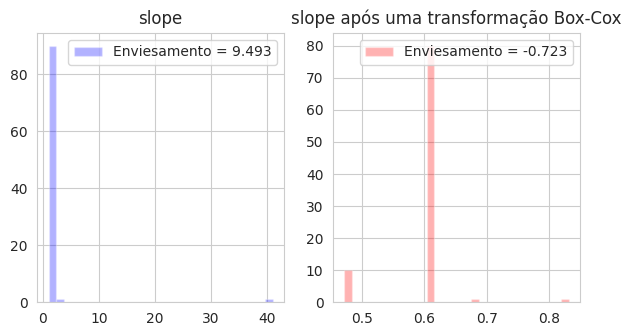

In [43]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(7,3.5))    
    ax[0].hist(df[feature], color='blue', bins=30, alpha=0.3, label='Enviesamento = %s' %(str(round(df[feature].skew(),3))) )
    ax[0].set_title(str(feature))   
    ax[0].legend(loc=0)
    ax[1].hist(df_bc[feature], color='red', bins=30, alpha=0.3, label='Enviesamento = %s' %(str(round(df_bc[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' após uma transformação Box-Cox')
    ax[1].legend(loc=0)
    plt.show()

In [44]:
for feature in features:
    delta = np.abs( df_bc[feature].skew() / df[feature].skew() )
    if delta < 1.0 :
        print('A feature %s está menos enviesado após uma transformação Box-Cox' %(feature))
    else:
        print('A feature %s está mais enviesado após uma transformação Box-Cox'  %(feature))

A feature id está menos enviesado após uma transformação Box-Cox
A feature age está menos enviesado após uma transformação Box-Cox
A feature sex está menos enviesado após uma transformação Box-Cox
A feature cp está menos enviesado após uma transformação Box-Cox
A feature trestbps está menos enviesado após uma transformação Box-Cox
A feature chol está menos enviesado após uma transformação Box-Cox
A feature fbs está menos enviesado após uma transformação Box-Cox
A feature restecg está menos enviesado após uma transformação Box-Cox
A feature thalach está mais enviesado após uma transformação Box-Cox
A feature exang está menos enviesado após uma transformação Box-Cox
A feature oldpeak está menos enviesado após uma transformação Box-Cox
A feature slope está menos enviesado após uma transformação Box-Cox


## **4) Treinando o modelo**

Nessa seção é feito o treinamento e medição de acurácia do classificador de Bayes, será utilizado o algoritmo classificador **GaussianNB**, já que todos elementos do nosso dataset se tratam de valores numéricos flutuantes em uma distribuição normal

In [45]:
numerical_columns = [column for column in X_test.columns ]
numerical_columns

['id',
 'age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope']

In [46]:
#Instanciando o classificador Gaussiano
gaussian_1 = GaussianNB()

#Método fit é responsável por treinar o modelo
gaussian_1.fit(X_train.values,y_train)

#Acurácia do modelo
acc_model_1 = gaussian_1.score(X_test,y_test)

print("Acurácia do modelo 1: {:03.2f}".format(acc_model_1))

def just_gauss(X_train, y_train):
  gaussian = GaussianNB()
  gaussian.fit(X_train.values,y_train)

  return gaussian.score

Acurácia do modelo 1: 0.42


sabemos que o campo id é inutil e não tem nenhuma informação sobre a condição do coração do paciente. se droparmos ele a acuracia aumenta ou diminui ?

In [47]:
df = df.drop(['id'], axis=1)

In [48]:
features = df.columns[:-1].tolist()

In [49]:
#Instanciando o classificador Gaussiano
gaussian_1 = GaussianNB()

#Método fit é responsável por treinar o modelo
gaussian_1.fit(X_train.values,y_train)

#Acurácia do modelo
acc_model_1 = gaussian_1.score(X_test,y_test)

print("Acurácia do modelo 1: {:03.2f}".format(acc_model_1))

def just_gauss(X_train, y_train):
  gaussian = GaussianNB()
  gaussian.fit(X_train.values,y_train)

  return gaussian.score

Acurácia do modelo 1: 0.42


observamos que a acuracia do modelo continua em 0.42. tinhamos visto anteriormente que correlação entre id e num era muito baixa. Ou seja, o campo id já fora ignorado durante o treinamento do classificador